In [70]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import pyreadr
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros
from tensorflow.keras.optimizers.legacy import Adam
import keras_tuner as kt
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from tensorflow.keras.losses import Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.compose import make_column_transformer
from NAM_models import ActivationLayer, FeatureNN, NAM
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

#-------------------------- import data --------------------------
'''we use the popular French Motor TPL insurance claim data '''
r_data = pyreadr.read_r("data/freMPL1.rda")
data = r_data['freMPL1']

# set column to the right category
data['HasKmLimit'] = data['HasKmLimit'].astype('category')

In [71]:
############################ 1. PREPROCESSING ############################

#-------------------------- filter claim data --------------------------

# drop unnecessary columns and filter policies with positive claims
claim = data[data["ClaimInd"] == 1].drop(columns = ["RecordBeg", "RecordEnd", "ClaimInd"]).reset_index(drop = True)
claim.head()

# global variables
cont_vars = ["LicAge", "DrivAge", "BonusMalus"] # continuous variables
ordinal_vars = ["RiskVar", "VehAge", "VehPrice", "VehMaxSpeed"] # ordinal categorical variables
nominal_vars = [] # nominal categorical variables
for var in claim.columns:
    if var not in cont_vars + ["Exposure", "ClaimAmount"] + ordinal_vars:
        nominal_vars.append(var)
cat_vars = nominal_vars + ordinal_vars


# #-------------------------- cap outliers for ClaimAmount --------------------------
log_claim = np.log(claim['ClaimAmount'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# apply caps
claim['ClaimAmount'] = np.exp(np.where(log_claim < lower_whisker, lower_whisker, log_claim))
claim['ClaimAmount'] = np.exp(np.where(log_claim > upper_whisker, upper_whisker, np.log(claim['ClaimAmount'])))


# -------------------------- remove outliers for BonusMalus --------------------------
claim["BonusMalus"] = np.where(claim["BonusMalus"] > 150, 150, claim["BonusMalus"])
claim["BonusMalus"] = np.where(claim["BonusMalus"] > 150, 150, claim["BonusMalus"])

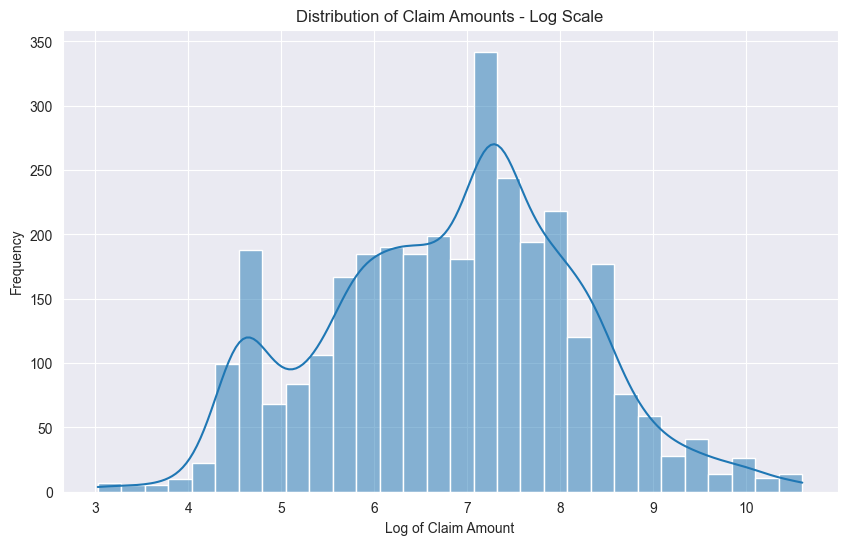

In [72]:
#-------------------------- distribution of log claim amount --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(claim['ClaimAmount']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of Claim Amounts - Log Scale')
plt.xlabel('Log of Claim Amount')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [73]:
#-------------------------- group rare categories --------------------------

threshold = 10 # categories with fewer than 10 observations will be grouped

### function to get the summary of number of instances per distinct category for categorical variable
def get_summary(data, column):
    summary = data[column].value_counts().reset_index()
    summary.columns = [column, 'Count']
    return summary

''' for SocioCateg, group rare categories into 1 category called Other'''
socio_summary = claim["SocioCateg"].value_counts()
categories_to_replace = socio_summary[socio_summary <= threshold].index # select the categories with 10 or fewer observations
claim["SocioCateg"] = claim["SocioCateg"].replace(categories_to_replace, 'Other')


''' for VehPrice, we need to make sure that the ordinal nature is retained.
W, X, Y, Z will be grouped into "W" group and B will be grouped with A to create 
an "AB" class.'''
claim["VehPrice"] = claim["VehPrice"].replace(['X', 'Y', 'Z'], 'W')
claim["VehPrice"] = claim["VehPrice"].replace(['A', 'B'], 'AB')


'''for VehEnergy and VehEngine, we remove 'electric' class'''
claim = claim[claim['VehEngine'] != 'electric'].reset_index(drop = True)

# remove unused categories
for var in nominal_vars:
    claim[var] = claim[var].cat.remove_unused_categories()

# check the number of distinct values after grouping
print(claim.shape)
print(get_summary(claim, "SocioCateg"))
print(get_summary(claim, "VehPrice"))
print(get_summary(claim, "VehEngine"))
print(get_summary(claim, "VehEnergy"))

(3264, 19)
   SocioCateg  Count
0       CSP50   1850
1       CSP60    409
2       CSP55    262
3        CSP1    196
4       CSP26     96
5       CSP66     93
6       CSP48     88
7       CSP42     80
8       CSP46     70
9       CSP37     44
10      Other     33
11      CSP49     30
12       CSP6     13
   VehPrice  Count
0         K    328
1         L    306
2         J    305
3         G    262
4         I    244
5         H    238
6         F    237
7         E    236
8         M    202
9         N    184
10        O    150
11        D    147
12        P    121
13        Q     88
14        R     64
15        C     39
16        S     29
17        U     22
18       AB     18
19        W     18
20        V     15
21        T     11
                      VehEngine  Count
0                     injection   2187
1  direct injection overpowered    830
2         injection overpowered    219
3                   carburation     28
  VehEnergy  Count
0   regular   2154
1    diesel   1110


/var/folders/30/wpb2n_hs72q5fz9yvp8c1cth0000gv/T/ipykernel_8631/3082177258.py:14: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  claim["SocioCateg"] = claim["SocioCateg"].replace(categories_to_replace, 'Other')
/var/folders/30/wpb2n_hs72q5fz9yvp8c1cth0000gv/T/ipykernel_8631/3082177258.py:20: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  claim["VehPrice"] = claim["VehPrice"].replace(['X', 'Y', 'Z'], 'W')
/var/folders/30/wpb2n_hs72q5fz9yvp8c1cth0000gv/T/ipykernel_8631/3082177258.py:21: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with Categor

In [74]:
#-------------------------- encode ordinal categorical variables --------------------------

# define the order for VehAge
vehage_order = ['0', '1', '2', '3', '4', '5', '6-7', '8-9', '10+']

# apply encoding for vehicle age
oe_vehage = OrdinalEncoder(categories = [vehage_order])
oe_vehage.fit(claim[["VehAge"]])

# apply encoding for VehPrice and VehMaxSpeed
oe_ordinal = OrdinalEncoder()
oe_ordinal.fit(claim[["VehPrice", "VehMaxSpeed"]])

# check the output
print(oe_vehage.categories_)
print(oe_ordinal.categories_)

[array(['0', '1', '2', '3', '4', '5', '6-7', '8-9', '10+'], dtype=object)]
[array(['AB', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W'], dtype=object), array(['1-130 km/h', '130-140 km/h', '140-150 km/h', '150-160 km/h',
       '160-170 km/h', '170-180 km/h', '180-190 km/h', '190-200 km/h',
       '200-220 km/h', '220+ km/h'], dtype=object)]


In [75]:
# -------------------------- apply the encoding directly into the data --------------------------

# get the ordinal values
vehage = oe_vehage.transform(claim[["VehAge"]])
ord_var = oe_ordinal.transform(claim[["VehPrice", "VehMaxSpeed"]])

# convert into dataframe
vehage_df = pd.DataFrame(vehage, columns = ["VehAge"])
ord_df = pd.DataFrame(ord_var, columns = ["VehPrice", "VehMaxSpeed"])

# replace relevant columns
claim["VehAge"] = vehage_df
claim[["VehPrice", "VehMaxSpeed"]] = ord_df

# check
claim.head()

,Exposure,LicAge,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage
0,0.500,224,3.0,Male,Other,Other,Professional,53,0,72,van,10.0,direct injection overpowered,diesel,2.0,0,1418.610272,19,None
1,0.218,169,6.0,Male,Other,CSP50,Private+trip to office,32,0,50,sedan,5.0,injection,diesel,4.0,B,146.255891,19,None
2,0.882,378,1.0,Female,Other,CSP60,Private,58,0,50,sedan,8.0,injection,regular,5.0,M1,102.590030,17,None
3,1.000,454,0.0,Male,Other,CSP50,Professional,56,0,50,sport utility vehicle,14.0,direct injection overpowered,diesel,8.0,M2,1562.356495,17,Private garage
4,0.097,446,0.0,Male,Alone,CSP48,Professional,57,0,50,sedan,9.0,direct injection overpowered,diesel,6.0,M1,2020.635952,18,None


In [76]:
############################ 2. NEURAL ADDITIVE MODEL - FULL IMPLEMENTATION ############################

# -------------------------- data preparation --------------------------

# remove certain columns due to collinearity issue
claim = claim.drop(columns = ["LicAge", "VehMaxSpeed"]).reset_index(drop = True)

'''we first fit a NAM with shallow subnets considering only main effects to select the most important variables'''
embedding_vars = ["SocioCateg", "VehBody", "VehClass", "VehUsage", "VehEngine"] # categorical variables with many levels that require embedding
binary_vars = [var for var in nominal_vars if var not in embedding_vars] # binary variables

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    claim.drop(["ClaimAmount"], axis = 1), claim[["ClaimAmount"]], test_size = 0.2, random_state = 1)


# -------------------------- apply encoding --------------------------

# define transformer - StandardScaler will be applied to all numeric and ordinal categorical variables
ct_NAM = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OrdinalEncoder(), embedding_vars + binary_vars),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)

# fit the transformer to the data
train = ct_NAM.fit_transform(X_train)
test = ct_NAM.transform(X_test)
feature_names = ct_NAM.get_feature_names_out()  # get the columns' names
print(feature_names)

['Exposure' 'SocioCateg' 'VehBody' 'VehClass' 'VehUsage' 'VehEngine'
 'Gender' 'MariStat' 'HasKmLimit' 'VehEnergy' 'Garage' 'VehAge' 'DrivAge'
 'BonusMalus' 'VehPrice' 'RiskVar']


In [88]:
# -------------------------- function to create a subnetwork --------------------------
# subnet for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(Lambda(lambda x: x - keras.ops.mean(x, axis = 0, keepdims = True), output_shape=(1,))) # zero center all output
    return model

In [89]:
# -------------------------- define NAM for main effects --------------------------

# for reproducibility
seed_value = 2024
keras.utils.set_random_seed(seed_value)

'''model architecture'''
inputs = []  # Store input layers
sub_outputs = []  # Outputs from each subnet

# model hyperparameters
num_neurons = 10
num_layers = 1
activation = 'leaky_relu'
embedding_dim = 3

# main effect
for name in feature_names:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)
    
    if name == "Exposure":  # Direct use without a subnet
        exposure_input = input_layer
    elif name in embedding_vars:
        # categorical variables will pass through an embedding layer
        embed_layer = Embedding(input_dim = claim[name].nunique(), 
                    output_dim = embedding_dim,
                    name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (embedding_dim,))(embed_layer)
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
        sub_output = subnet(embed_layer_reshape)
        sub_outputs.append(sub_output)
    else:
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs.append(sub_output)

# combine subnets' outputs
subnets = Concatenate(name = f"subnet_output")(sub_outputs)
output_layer = Dense(1, activation = "exponential", name = "output_layer")(subnets)

# multiply output with exposure
final_output = Multiply(name = "final_output")([exposure_input, output_layer])
model_main = Model(inputs = inputs, outputs = final_output)

# plot_model(model_main, show_layer_names = True, show_shapes = True)

In [90]:
# -------------------------- compile and fit the model --------------------------
# we will use a Gamma loss function
def gamma_log_likelihood(y_true, y_pred):
    y_pred = keras.ops.clip(y_pred, 1e-7, 1e30)
    return keras.ops.mean(y_true/y_pred - keras.ops.log(y_true/y_pred))

# create training data consistent with the model architecture
X_train_split = []
for i in range(len(feature_names)):
    X_train_split.append(train[:, i])

# compile
model_main.compile(optimizer = 'RMSprop', loss = gamma_log_likelihood, metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)

%time hist_main = model_main.fit(X_train_split, y_train, epochs = 1_000, \
    callbacks = [es], validation_split = 0.25)

Epoch 1/1000


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5796.6064 - mean_absolute_error: 2189.3948 - root_mean_squared_error: 4495.7544 - val_loss: 5438.5127 - val_mean_absolute_error: 2057.8066 - val_root_mean_squared_error: 4483.3706
Epoch 2/1000
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5373.8896 - mean_absolute_error: 2189.3621 - root_mean_squared_error: 4495.7373 - val_loss: 5043.4268 - val_mean_absolute_error: 2057.7708 - val_root_mean_squared_error: 4483.3535
Epoch 3/1000
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5039.2134 - mean_absolute_error: 2189.3252 - root_mean_squared_error: 4495.7188 - val_loss: 4701.5098 - val_mean_absolute_error: 2057.7300 - val_root_mean_squared_error: 4483.3350
Epoch 4/1000
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4733.2920 - mean_absolute_error: 2189.2847 - root_mean_squared_error: 4495.6982 - val_loss: 4398.6401 - val_mean_absolute_error: 2057.6863 - val_root_mean_squared_error: 4483.3159
Epoch 5/1000
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

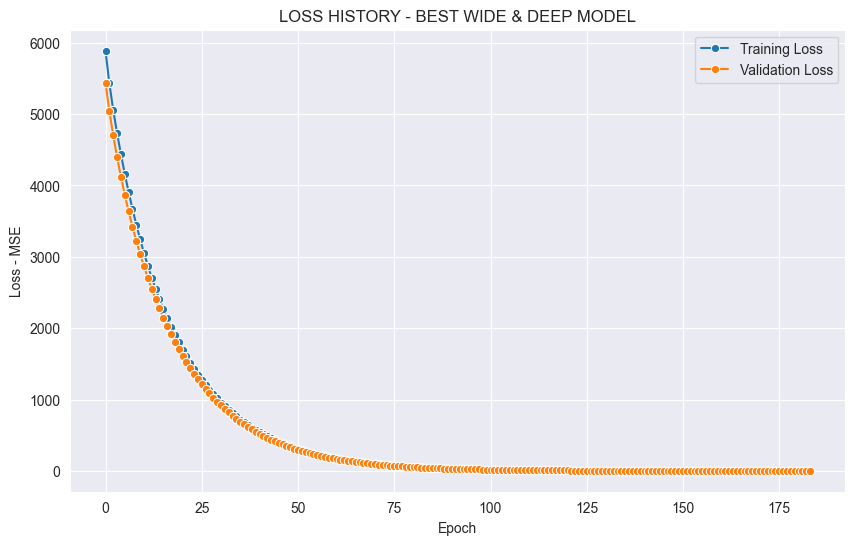

In [91]:
# plotting the loss history
plt.figure(figsize = (10, 6))
sns.set_style("darkgrid")
sns.lineplot(data = hist_main.history['loss'], label = 'Training Loss', marker = 'o')
sns.lineplot(data = hist_main.history['val_loss'], label = 'Validation Loss', marker = 'o')
plt.title('LOSS HISTORY - BEST WIDE & DEEP MODEL')
plt.xlabel('Epoch')
plt.ylabel('Loss - MSE')
plt.legend()
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.show()

53/82 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step 

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


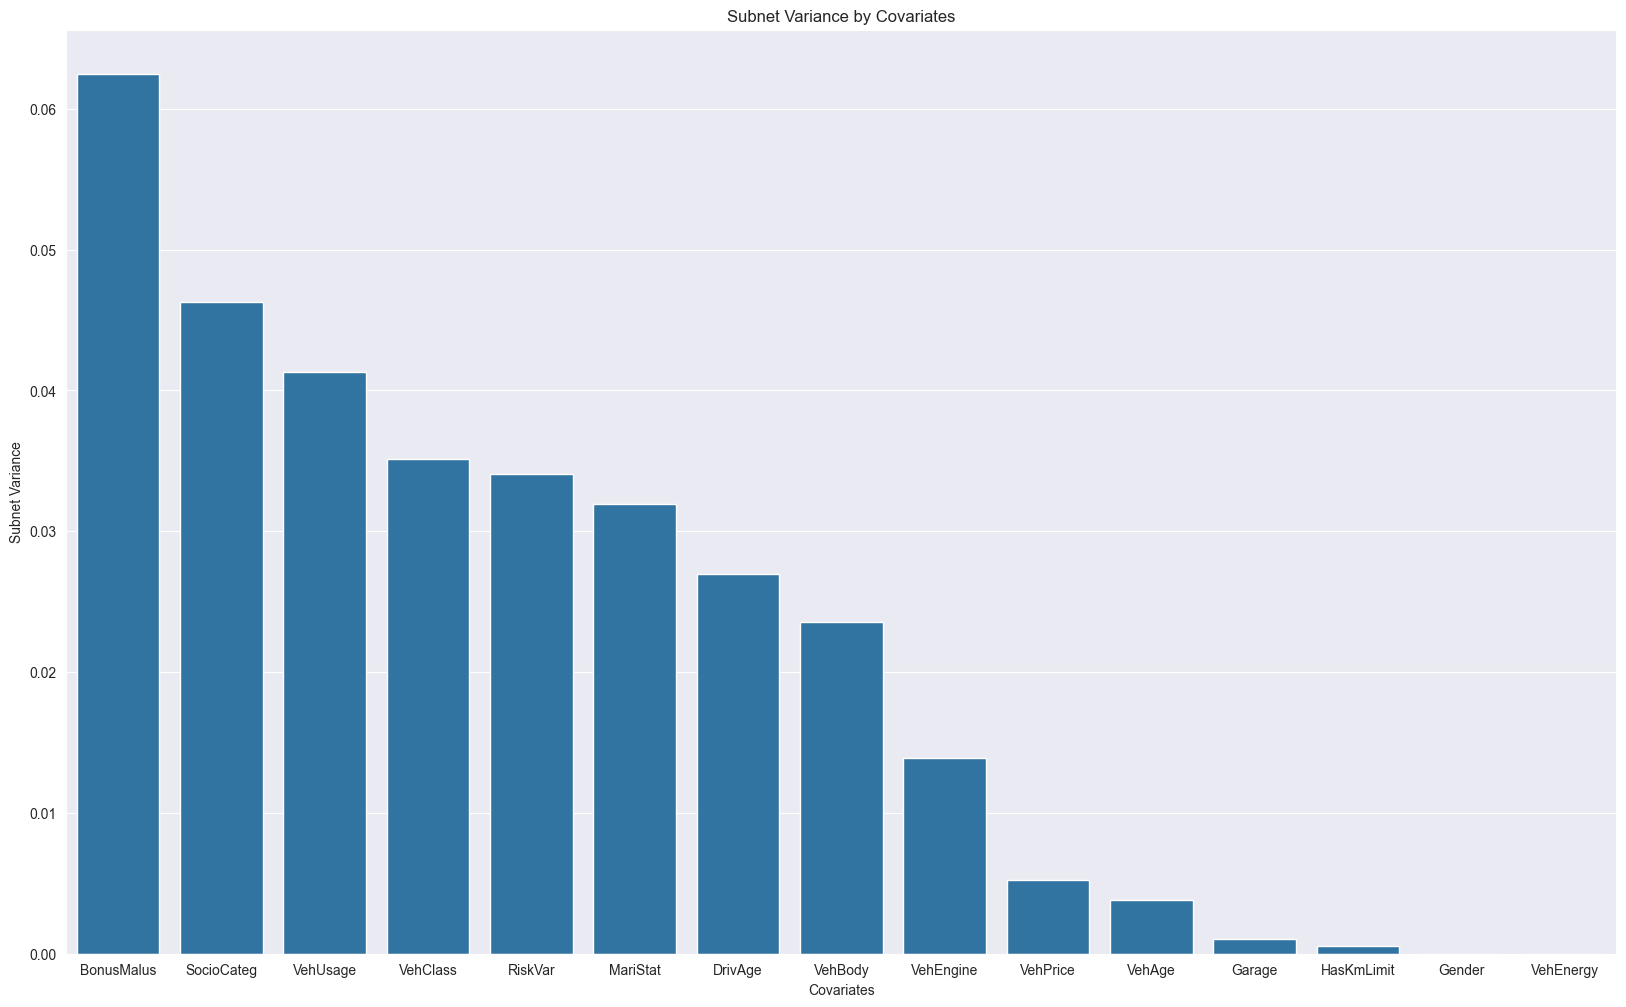

In [92]:
# -------------------------- quantify variable importance --------------------------
subnet_output_layer = model_main.get_layer("subnet_output")  # Get the layer
subnet_output_model = Model(inputs = model_main.inputs, outputs = subnet_output_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_split) # get the subnetwork output
subnet_weights = model_main.get_layer("output_layer").get_weights()[0]

# get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:,i])*subnet_weights[i][0]**2)
covariates = [name for name in feature_names if name != "Exposure"]

# -------------------------- plot the variable importance --------------------------
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 12))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

In [22]:
# -------------------------- get the predictions of main effect --------------------------
'''these predictions will then be used to calculate the residuals to select pairwise interaction effect'''

# split the data to facilitate NAM
train_main_split = []
test_main_split = []
for i in range(len(feature_names)):
    train_main_split.append(train[:, i])
    test_main_split.append(test[:, i])

# make predictions
y_train_main_pred = model_main.predict(train_main_split)
y_test_main_pred = model_main.predict(test_main_split)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [157]:
# -------------------------- data preparation --------------------------
important_vars = [var for var in varimp_sorted["Covariates"] if 
                  varimp_sorted[varimp_sorted["Covariates"] == var]["Subnet Variance"].iloc[0] > 1]
unimportant_vars = [var for var in varimp_sorted["Covariates"] if var not in important_vars] # unimportant variables
train_df = pd.DataFrame(train, columns = feature_names)
test_df = pd.DataFrame(test, columns = feature_names)
train_NAM = train_df.drop(columns = unimportant_vars).reset_index(drop = True)
test_NAM = test_df.drop(columns = unimportant_vars).reset_index(drop = True)
y_train_res = y_train - y_train_main_pred # interaction effects will be fitted on the residuals of the model in the previous step
y_test_res = y_test - y_test_main_pred # interaction effects will be fitted on the residuals of the model in the previous step
train_NAM.head()

,Exposure,VehBody,VehClass,VehUsage,VehEngine,DrivAge,VehPrice,RiskVar
0,0.486,2.0,1.0,0.0,3.0,1.390444,-1.521354,0.573678
1,0.833,5.0,1.0,1.0,2.0,0.196544,-1.278492,0.365438
2,0.528,5.0,1.0,2.0,2.0,1.324116,-0.792767,-1.092245
3,0.625,5.0,2.0,0.0,1.0,-0.599388,-0.064180,0.573678
4,0.916,3.0,4.0,2.0,1.0,0.660839,0.421544,-1.092245


In [158]:
#-------------------------- identify the interaction effect to fit the model --------------------------
interaction_strength = {}
train_interaction = train_NAM.drop(columns = ["Exposure"]).reset_index(drop = True)
test_interaction = test_NAM.drop(columns = ["Exposure"]).reset_index(drop = True)
columns = train_interaction.columns

# Iterate over all combinations of two columns
for col1, col2 in itertools.combinations(columns, 2):
    # Create a new DataFrame with the pair of columns
    X_train_pair = train_interaction[[col1, col2]]
    X_test_pair = test_interaction[[col1, col2]]
    
    # Fit a shallow decision tree
    tree = DecisionTreeRegressor(max_depth = 2)
    tree.fit(X_train_pair, y_train_res)
    
    # Predict on the test set
    y_test_res_pred = tree.predict(X_test_pair)
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test_res.values, y_test_res_pred)
    rmse = np.sqrt(mse)
    
    # Store the result in the dictionary
    interaction_strength[f"{col1} & {col2}"] = rmse

# Create a DataFrame from the dictionary and sort it
interaction_df = pd.DataFrame(list(interaction_strength.items()), columns=['Interaction', 'RMSE'])
interaction_df = interaction_df.sort_values(by = 'RMSE', ascending = True)

# Display the sorted DataFrame
interaction_df.reset_index(drop=True, inplace=True)
interaction_df

,Interaction,RMSE
0,DrivAge & VehPrice,4808.503396
1,VehEngine & DrivAge,4808.991818
2,VehBody & DrivAge,4808.991818
3,VehUsage & DrivAge,4808.991818
4,VehClass & DrivAge,4808.991818
5,VehClass & RiskVar,4810.187733
6,VehPrice & RiskVar,4815.386155
7,VehBody & VehClass,4816.901541
8,VehBody & VehPrice,4818.644348
9,VehBody & RiskVar,4825.329722


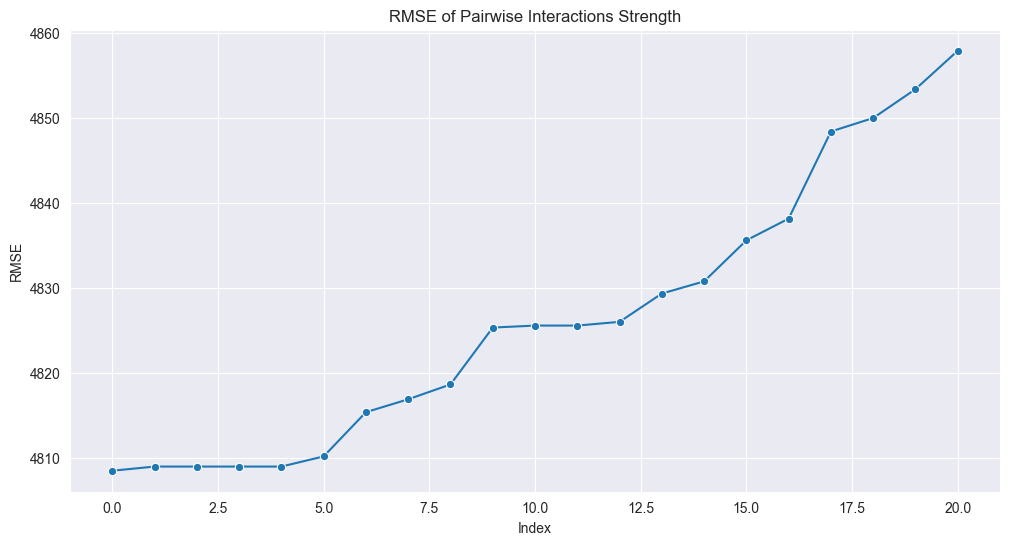

In [159]:
# Generate the line plot using Seaborn
plt.figure(figsize = (12, 6))
sns.lineplot(data = interaction_df, x = interaction_df.index, y = 'RMSE', marker = 'o')
plt.xlabel('Index')
plt.ylabel('RMSE')
plt.title('RMSE of Pairwise Interactions Strength')
plt.grid(True)
plt.show()

In [160]:
# select important interaction effect
top_interactions = interaction_df.head(5)
pairwise_interactions = [tuple(interaction.split(' & ')) for interaction in top_interactions['Interaction']]
pairwise_interactions

[('DrivAge', 'VehPrice'),
 ('VehEngine', 'DrivAge'),
 ('VehBody', 'DrivAge'),
 ('VehUsage', 'DrivAge'),
 ('VehClass', 'DrivAge')]

In [161]:
# -------------------------- define specialized layers & constraints for MIN-MAX network --------------------------

'''create a specialized MIN layer'''
class MinLayer(Layer):
    def __init__(self, **kwargs):
        super(MinLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return K.min(inputs, axis=-1, keepdims=True)

'''create a specialized MAX layer'''
class MaxLayer(Layer):
    def __init__(self, **kwargs):
        super(MaxLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return K.max(inputs, axis=-1, keepdims=True)

# Custom constraints
'''Adapted from: https://keras.io/api/layers/constraints/ '''
class PositiveConstraint(Constraint):
    def __call__(self, w):
        return w * tf.cast(tf.greater_equal(w, 0.), dtype = w.dtype)

class NegativeConstraint(Constraint):
    def __call__(self, w):
        return w * tf.cast(tf.less_equal(w, 0.), dtype = w.dtype)


# -------------------------- define the architecture for MIN-MAX network --------------------------
def create_MINMAX(input_layer, num_groups, neurons_per_group, activation, monotonicity_list, model_name):
    
    """Examples of monotonicity list: ["positive", "negative", "none"]. This example shows an input of size 3,
    where all weights connecting the first input neuron with the dense layer should always be positive; negative for
    the second neuron and nothing is applied for the third neuron """

    # Define the architecture of each group
    min_layers = [] # store output of the MIN layer
    input_size = input_layer.shape[1]
    for i in range(num_groups):
        
        group_layers = []
        ''' we need to loop through each neuron for each group to apply monotonicity constraint'''
        for j in range(input_size):
            if monotonicity_list[j] == "positive":
                constraint = PositiveConstraint()
            elif monotonicity_list[j] == "negative":
                constraint = NegativeConstraint()
            else:
                constraint = None
            dense_layer = Dense(neurons_per_group, activation=activation, kernel_constraint=constraint)(input_layer[:, j:j+1])
            group_layers.append(dense_layer)
        
        # Concatenate all neurons and apply MinLayer for the current group
        concatenated_group = Concatenate(axis=-1)(group_layers)
        min_layer = MinLayer()(concatenated_group)
        min_layers.append(min_layer)
    
    # Concatenate the min values
    concatenated_min_values = Concatenate(axis = -1)(min_layers)
    
    # Compute the max of concatenated min values
    output_layer = MaxLayer()(concatenated_min_values)
    
    # Create the model
    model = Model(inputs = input_layer, outputs = output_layer, name = model_name)
    return model

In [162]:
# -------------------------- data preparation --------------------------

# monotonicity list
monotonicity = {"BonusMalus": "positive"}

# list of embedding and binary vars
embedding_vars_filtered = ["SocioCateg", "VehClass", "VehUsage"] # categorical variables with many levels that require embedding
feature_names_filtered = [var for var in feature_names if var not in unimportant_vars]


# -------------------------- define the complete NAM --------------------------
def build_NAM(hp):

    global monotonicity
    # list of layers
    inputs = []  # Store input layers
    sub_outputs = []  # Outputs from each subnet
    interactions_input = {} # used to store layers as input for pairwise interaction effect subnet

    # hyperparameters
    num_layers_main = hp.Int('num_layers', 2, 4) # number of hidden layers for main effects' subnets
    num_layers_interaction = hp.Int('num_layers', 2, 8, step = 2) # number of hidden layers for interaction effects' subnets
    units_main = hp.Int('units_main', 5, 15, step = 2) # number of units per layer for main effect
    units_interaction = hp.Int('units_interaction', 15, 30, step = 5) # number of units per layer for interaction effect
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'swish', 'gelu'])
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step = 0.1)
    embedding_dim = hp.Int("embedding_dimension", 2, 4) # embedding dimension for categorical variables
    MINMAX_groups_main = hp.Int('num_layers', 3, 8) # number of groups of MINMAX network for main effect
    MINMAX_groups_interaction = hp.Int('num_layers', 5, 10) # number of groups of MINMAX network for interaction effect
    MINMAX_neurons_main = hp.Int('num_layers', 3, 8) # number of neurons per group of MINMAX network for main effect
    MINMAX_neurons_interaction = hp.Int('num_layers', 5, 10) # number of neurons per group of MINMAX network for interaction effect
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate for optimizer

    # main effect
    for name in feature_names_filtered:
        
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)
        interactions_input[name] = input_layer
        
        # subnetwork
        if name == "Exposure":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in embedding_vars_filtered:
            # categorical variables will pass through an embedding layer
            embed_layer = Embedding(input_dim = claim[name].nunique(), 
                        output_dim = embedding_dim,
                        name = f"embed_{name}")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (embedding_dim,))(embed_layer)
            interactions_input[name] = embed_layer_reshape # used for pairwise interaction effect
            subnet = create_subnet(num_layers_main, units_main, activation, f"{name}_subnetwork", dropout_rate)
            sub_output = subnet(embed_layer_reshape)
            sub_outputs.append(sub_output)
        else:
            if name in monotonicity:
                subnet = create_MINMAX(input_layer, num_groups = MINMAX_groups_main, 
                                    neurons_per_group = MINMAX_neurons_main, activation = activation, 
                                    monotonicity_list = [monotonicity[name]],
                                    model_name = f"{name}_subnetwork")
            else:
                subnet = create_subnet(num_layers_main, units_main, activation, f"{name}_subnetwork", dropout_rate)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)

    
    # pairwise interactions
    for (var1, var2) in pairwise_interactions:

        # get the relevant input layers
        input_layer1 = interactions_input[var1]
        input_layer2 = interactions_input[var2]

        # concatenate
        pairwise_input = Concatenate()([input_layer1, input_layer2])
        
        # create the monotonicity list
        monotonicity_list = []
        if var1 in monotonicity:
            monotonicity_list.append(monotonicity[var1])
        else:
            for _ in range(input_layer1.shape[1]):
                monotonicity_list.append("none")
        if var2 in monotonicity:
            monotonicity_list.append(monotonicity[var2])
        else:
            for _ in range(input_layer2.shape[1]):
                monotonicity_list.append("none")
                
        # subnetworks
        if var1 in monotonicity or var2 in monotonicity:
            pairwise_subnet = create_MINMAX(pairwise_input, num_groups = MINMAX_groups_interaction, 
                                            neurons_per_group = MINMAX_neurons_interaction, 
                                            activation = activation, 
                                            monotonicity_list = monotonicity_list,
                                            model_name = f"{var1}_{var2}_subnetwork")
        else:
            pairwise_subnet = create_subnet(num_layers_interaction, units_interaction, activation, 
                                            f"{var1}_{var2}_subnetwork", dropout_rate)
        pairwise_output = pairwise_subnet(pairwise_input)
        sub_outputs.append(pairwise_output)

    # combine subnets' outputs
    subnets = Concatenate(name = f"subnet_output")(sub_outputs)
    output_layer = Dense(1, activation = "softplus")(subnets)

    # multiply output with exposure
    final_output = Multiply()([exposure_input, output_layer + 1e-3])
    model = Model(inputs = inputs, outputs = final_output)

    #compile and return model
    model.compile(optimizer = Adam(learning_rate = lr), loss = 'mean_squared_error', 
                  metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    return model

In [163]:
# -------------------------- compile and fit the model --------------------------

# hyperparameter tuning
tuner_NAM = kt.RandomSearch(
    build_NAM,
    objective = 'val_loss',
    max_trials = 20,  # Increased trials due to additional hyperparameters
    directory = "hyperparameter_tuning_NAM_freMPL1",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True)

# training data need to be split into different arrays, each correponds to input for a particular subnet
X_train_NAM_split = []
for i in range(len(feature_names_filtered)):
    X_train_NAM_split.append(np.array(train_NAM)[:, i])

# search for the best model
tuner_NAM.search(X_train_NAM_split, y_train,
            epochs = 500,
            validation_split = 0.25,
            callbacks = [es])

# get the best model
model_NAM = tuner_NAM.get_best_models()[0]
tuner_NAM.results_summary(1)

Trial 20 Complete [00h 00m 36s]
val_loss: 18591316.0

Best val_loss So Far: 17684116.0
Total elapsed time: 00h 10m 45s
Results summary
Results in hyperparameter_tuning_NAM_freMPL1/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
num_layers: 4
units_main: 11
units_interaction: 30
activation: relu
dropout_rate: 0.30000000000000004
embedding_dimension: 4
learning_rate: 0.0008151332617212836
Score: 17684116.0


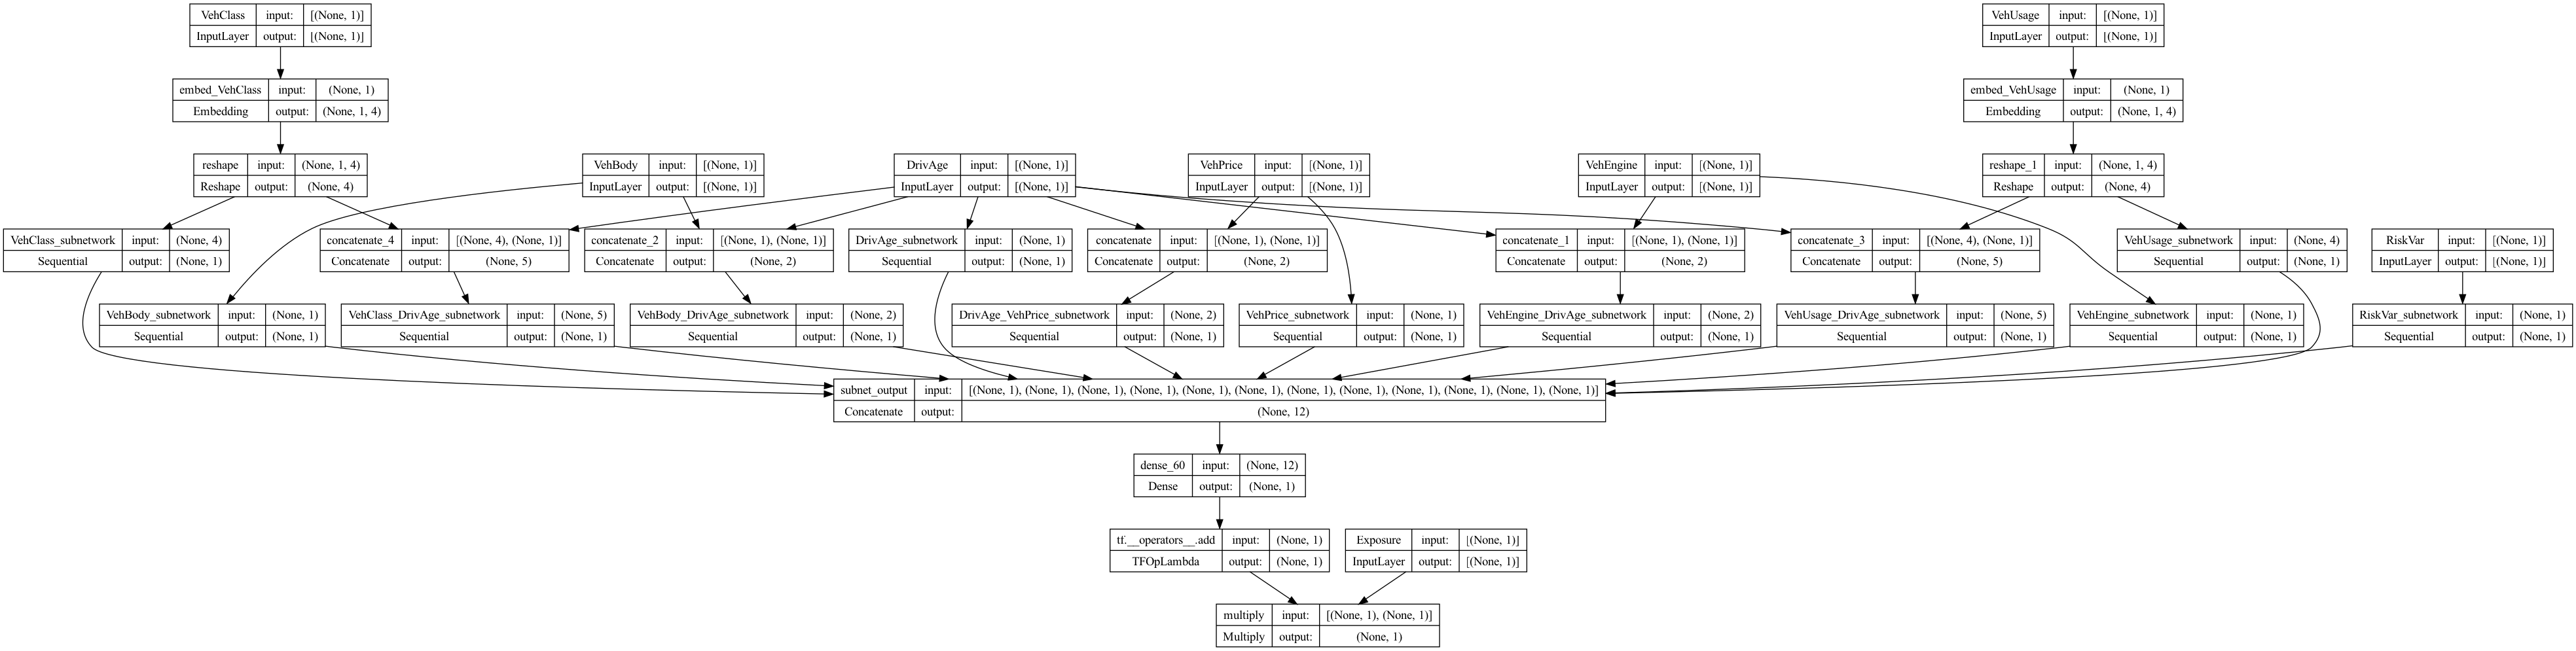

In [164]:
plot_model(model_NAM, show_layer_names = True, show_shapes = True)

In [165]:
#-------------------------- evaluate on testing data --------------------------
# split testing data into different sets
X_test_NAM_split = []
for i in range(len(feature_names_filtered)):
    X_test_NAM_split.append(np.array(test_NAM)[:, i])

# evaluation
_, nam_rmse, nam_mae = model_NAM.evaluate(X_test_NAM_split, y_test)

21/21 [==============================] - 0s 1ms/step - loss: 26358230.0000 - root_mean_squared_error: 5134.0269 - mean_absolute_error: 2224.2666


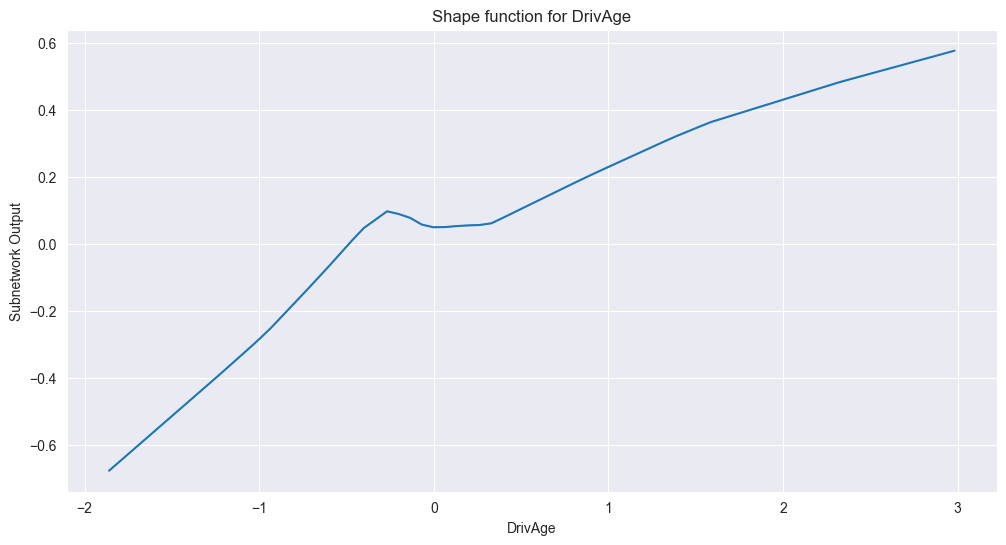

In [170]:
#-------------------------- view the shape function --------------------------

# get the model output
output_layer = model_NAM.get_layer("subnet_output")
output_function = K.function(model_NAM.inputs, [output_layer.output])
output_values = output_function(X_train_NAM_split)[0] # get the subnetwork output

# create the plot
var_name = "DrivAge"
var_index = feature_names_filtered.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_NAM_split[var_index], y = output_values[:,var_index-1].flatten())
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

In [171]:
############################ 3. GLM ############################

# -------------------------- train-test split --------------------------
# 'we will drop LicAge and VehMaxSpeed from the training data due to multicollinearity issue'
# X_train_GLM = X_train.drop(columns = ["LicAge", "VehMaxSpeed"]).reset_index(drop = True)
# X_test_GLM = X_test.drop(columns = ["LicAge", "VehMaxSpeed"]).reset_index(drop = True)

# -------------------------- apply encoding --------------------------
# define transformer
ct_GLM = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OneHotEncoder(drop = 'first'), nominal_vars),
    remainder = "passthrough",
    verbose_feature_names_out = False
)

# fit & transform
train_GLM = ct_GLM.fit_transform(X_train)
test_GLM = ct_GLM.transform(X_test)

# get the exposure
expo_train = train_GLM[:, 0]
expo_test = test_GLM[:, 0]

# remove exposure from data
train_GLM = train_GLM[:,1:]
test_GLM = test_GLM[:,1:]

# add intercept terms
train_GLM = sm.add_constant(train_GLM)
test_GLM = sm.add_constant(test_GLM)

In [173]:
# -------------------------- fit a GLM with Gaussian distribution --------------------------
model = sm.GLM(y_train, train_GLM, family = sm.families.Gamma(sm.families.links.log()), offset = np.log(expo_train))
model_GLM = model.fit()

# get model summary
print(model_GLM.summary())

/Users/tupho/miniconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                 2611
Model:                            GLM   Df Residuals:                     2568
Model Family:                   Gamma   Df Model:                           42
Link Function:                    log   Scale:                          5.2516
Method:                          IRLS   Log-Likelihood:                -23835.
Date:                Tue, 06 Aug 2024   Deviance:                       5684.8
Time:                        17:07:30   Pearson chi2:                 1.35e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.04846
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8378      1.028      7.621      0.0

In [174]:
# -------------------------- evaluate model performance --------------------------
GLM_pred = model_GLM.predict(test_GLM, offset = np.log(expo_test))
GLM_rmse = np.sqrt(mean_squared_error(y_test, GLM_pred))
GLM_mae = mae(y_test, GLM_pred)
print(GLM_rmse)
print(GLM_mae)

5512.6424186990025
3336.882267759716


In [175]:
############################ 4. ARTIFICIAL NEURAL NETWORKS ############################

#-------------------------- define the neural network architecture--------------------------
# separate multi-level categorical columns from other columns
train_cat = []
val_cat = []
test_cat = []
cat_index = []
for i in range(len(embedding_vars)):
    index = np.where(feature_names == embedding_vars[i])[0][0]
    train_cat.append(train[:,index])
    test_cat.append(test[:,index])
    cat_index.append(index)


# exposure
expo_train = train[:,0]
expo_test = test[:,0]
                    
# drop exposure and nominal categorical columns
train_others = np.delete(train, [0] + cat_index, axis = 1)
test_others = np.delete(test, [0] + cat_index, axis = 1)


#-------------------------- define the neural network architecture--------------------------
def build_NN(hp):

    # tuning hyperparameters
    num_layers = hp.Int('num_dense_layers', 3, 8, step = 1) # number of hidden layers
    num_neurons = hp.Int(f'num_neurons_first_hidden', 200, 800, step = 10) # number of neurons in the first hidden layers
    dropout_rate = hp.Float(f'dropout_rate', min_value = 0.2, max_value = 0.5, step = 0.1) # dropout rate
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate
    embedding_dim = hp.Int('embedding_dim', 2, 5, step = 1) # dimension of the embedding layer
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'swish', 'gelu'])

    # embedding layers for nominal categorical variables with > 4 levels
    cat_inputs = [] # input layers for categorical features
    embedding_layers = [] # embedding layers
    for cat_column in embedding_vars:

        # input layers
        cat_input = Input(shape = (1,), name = f"input_{cat_column}") 
        cat_inputs.append(cat_input)

        # embedding layers
        embed_layer = Embedding(input_dim = claim[cat_column].nunique(), 
                                output_dim = embedding_dim, 
                                name = f"embed_{cat_column}")(cat_input)
        embed_layer_reshape = Reshape(target_shape = (embedding_dim,), name = f"reshape_{cat_column}")(embed_layer)
        embedding_layers.append(embed_layer_reshape)

    # combine embedding with other inputs  
    other_inputs = Input(shape = train_others.shape[1:])
    inputs = Concatenate(name = "combined_input")(embedding_layers + [other_inputs])


    # dense layers
    x = inputs
    for i in range(num_layers):
        num_units = num_neurons - i*int(num_neurons/num_layers)
        x = Dense(units = num_units, activation = activation)(x)
        x = Dropout(dropout_rate)(x)
    
    # skip connection
    concat = Concatenate()([x,inputs])

    # output layer with exposure
    lambda_ = Dense(1, "softplus")(concat)
    exposure_layer = Input(shape = (1,), name = "exposure") # exposure
    output = Multiply()([lambda_ + 1e-4, exposure_layer]) # adjust the predicted claim by the exposure

    # model
    model = Model([exposure_layer] + [other_inputs] + cat_inputs, output)
    
    # build model
    model.compile(optimizer = Adam(learning_rate = lr),
            loss = "mean_squared_error",
            metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    
    return model

In [177]:
# -------------------------- tune and fit the model --------------------------
# tuner
tuner_NN = kt.RandomSearch(
    build_NN,
    objective = 'val_loss',
    max_trials = 20,
    directory = "hyperparameter_tuning_NN_freMPL1",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True, verbose = 0)

# search for the best model
tuner_NN.search([expo_train, train_others, train_cat], y_train,
        epochs = 1_000,
        validation_split = 0.25,
        callbacks = [es])

# get the best model
model_NN = tuner_NN.get_best_models()[0]
tuner_NN.results_summary(1)

Trial 20 Complete [00h 00m 09s]
val_loss: 17004482.0

Best val_loss So Far: 17004482.0
Total elapsed time: 00h 02m 24s
Results summary
Results in hyperparameter_tuning_NN_freMPL1/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 19 summary
Hyperparameters:
num_dense_layers: 6
num_neurons_first_hidden: 590
dropout_rate: 0.30000000000000004
learning_rate: 0.006600507698841165
embedding_dim: 5
activation: swish
Score: 17004482.0


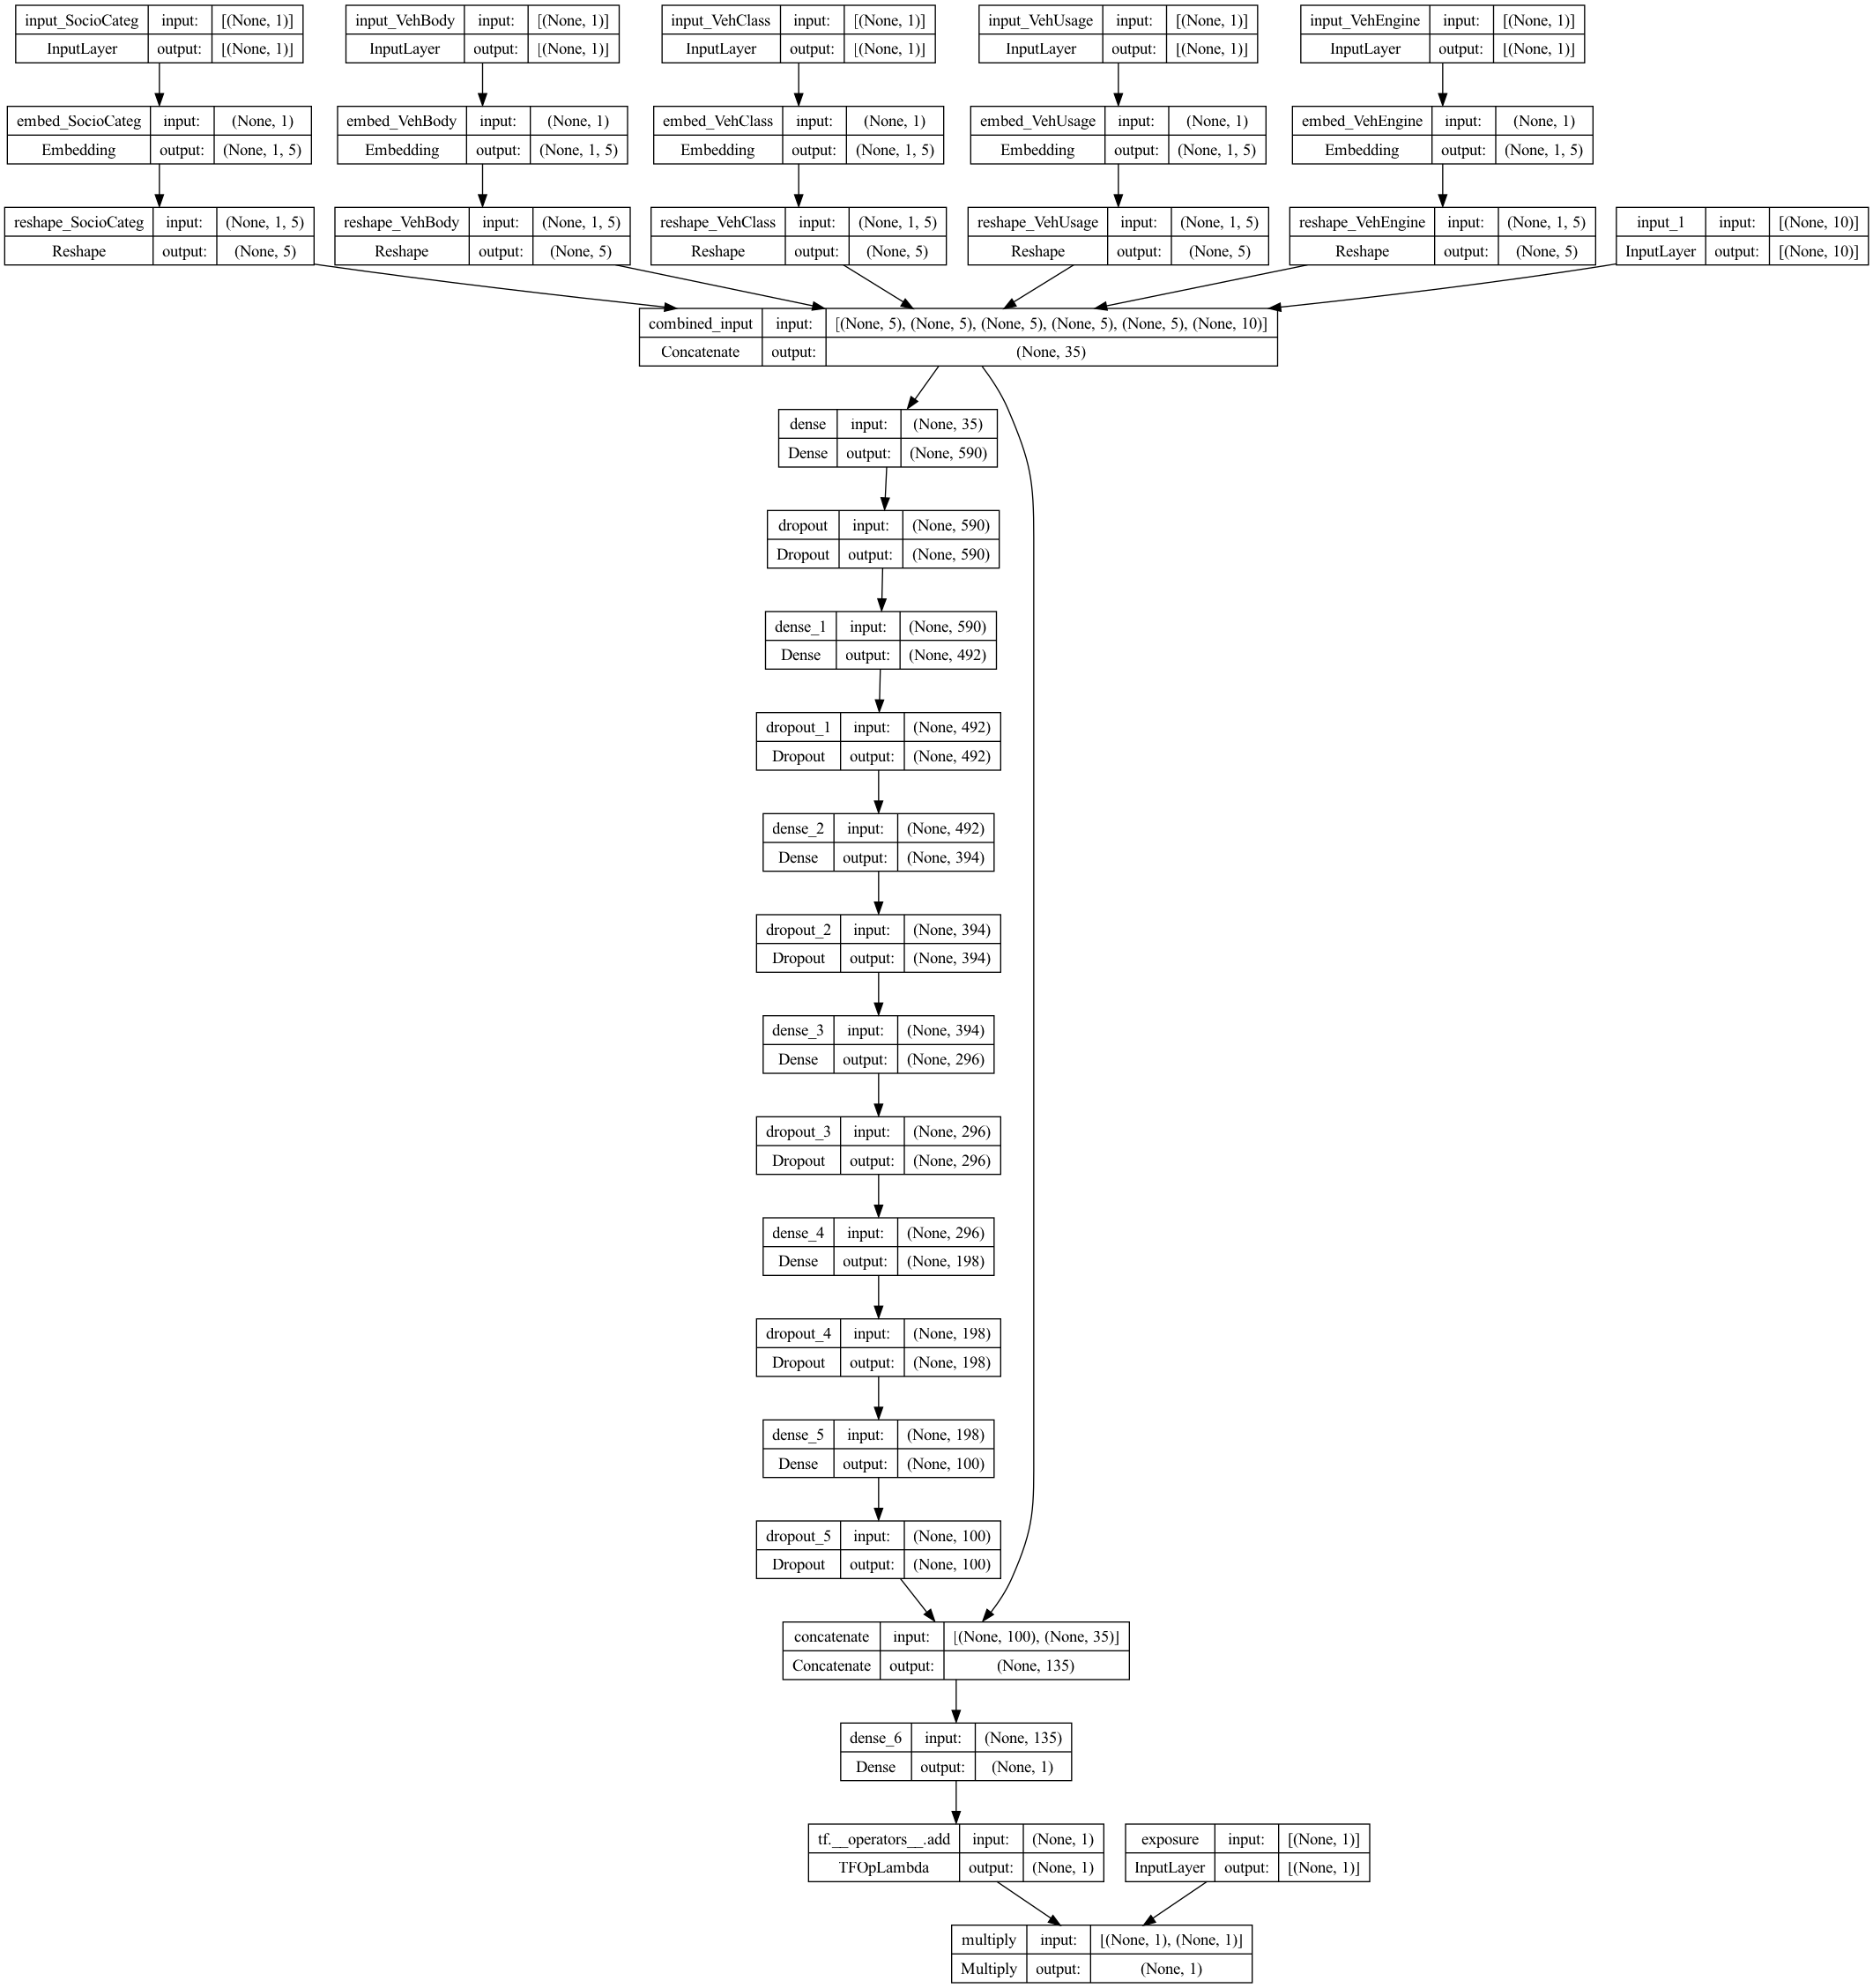

In [178]:
#-------------------------- plot model --------------------------
plot_model(model_NN, show_layer_names = True, show_shapes = True)

In [179]:
#-------------------------- evaluate on test set --------------------------
_, nn_rmse, nn_mae = model_NN.evaluate([expo_test, test_others, test_cat], y_test)

21/21 [==============================] - 0s 2ms/step - loss: 25199300.0000 - root_mean_squared_error: 5019.8906 - mean_absolute_error: 2190.9519


In [187]:
############################ 5. NAM WITH GAMMA DISTRIBUTION ############################

# Custom loss function for Gamma distribution likelihood
class GammaLikelihoodLoss(Loss):
    def call(self, y_true, y_pred):
        shape = y_pred[:, 0]
        scale = y_pred[:, 1]
        epsilon = 1e-8

        # Ensure shape and scale are positive
        shape = tf.math.maximum(shape, epsilon)
        scale = tf.math.maximum(scale, epsilon)

        log_prob = shape * tf.math.log(scale) + (shape - 1) * tf.math.log(y_true + epsilon) - y_true/scale - tf.math.lgamma(shape)
        return -tf.reduce_mean(log_prob)


# -------------------------- define NAM with Gamma loss --------------------------
def build_NAM_gamma(hp):

    global monotonicity
    # list of layers
    inputs = []  # Store input layers
    sub_outputs = []  # Outputs from each subnet
    interactions_input = {} # used to store layers as input for pairwise interaction effect subnet

    # hyperparameters
    num_layers_main = hp.Int('num_layers', 2, 4) # number of hidden layers for main effects' subnets
    num_layers_interaction = hp.Int('num_layers', 2, 8, step = 2) # number of hidden layers for interaction effects' subnets
    units_main = hp.Int('units_main', 5, 15, step = 2) # number of units per layer for main effect
    units_interaction = hp.Int('units_interaction', 15, 30, step = 5) # number of units per layer for interaction effect
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'swish', 'gelu'])
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step = 0.1)
    embedding_dim = hp.Int("embedding_dimension", 2, 4) # embedding dimension for categorical variables
    MINMAX_groups_main = hp.Int('num_layers', 3, 8) # number of groups of MINMAX network for main effect
    MINMAX_groups_interaction = hp.Int('num_layers', 5, 10) # number of groups of MINMAX network for interaction effect
    MINMAX_neurons_main = hp.Int('num_layers', 3, 8) # number of neurons per group of MINMAX network for main effect
    MINMAX_neurons_interaction = hp.Int('num_layers', 5, 10) # number of neurons per group of MINMAX network for interaction effect
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate for optimizer

    # main effect
    for name in feature_names_filtered:
        
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)
        interactions_input[name] = input_layer
        
        # subnetwork
        if name == "Exposure":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in embedding_vars_filtered:
            # categorical variables will pass through an embedding layer
            embed_layer = Embedding(input_dim = claim[name].nunique(), 
                        output_dim = embedding_dim,
                        name = f"embed_{name}")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (embedding_dim,))(embed_layer)
            interactions_input[name] = embed_layer_reshape # used for pairwise interaction effect
            subnet = create_subnet(num_layers_main, units_main, activation, f"{name}_subnetwork", dropout_rate)
            sub_output = subnet(embed_layer_reshape)
            sub_outputs.append(sub_output)
        else:
            if name in monotonicity:
                subnet = create_MINMAX(input_layer, num_groups = MINMAX_groups_main, 
                                    neurons_per_group = MINMAX_neurons_main, activation = activation, 
                                    monotonicity_list = [monotonicity[name]],
                                    model_name = f"{name}_subnetwork")
            else:
                subnet = create_subnet(num_layers_main, units_main, activation, f"{name}_subnetwork", dropout_rate)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)

    
    # pairwise interactions
    for (var1, var2) in pairwise_interactions:

        # get the relevant input layers
        input_layer1 = interactions_input[var1]
        input_layer2 = interactions_input[var2]

        # concatenate
        pairwise_input = Concatenate()([input_layer1, input_layer2])
        
        # create the monotonicity list
        monotonicity_list = []
        if var1 in monotonicity:
            monotonicity_list.append(monotonicity[var1])
        else:
            for _ in range(input_layer1.shape[1]):
                monotonicity_list.append("none")
        if var2 in monotonicity:
            monotonicity_list.append(monotonicity[var2])
        else:
            for _ in range(input_layer2.shape[1]):
                monotonicity_list.append("none")
                
        # subnetworks
        if var1 in monotonicity or var2 in monotonicity:
            pairwise_subnet = create_MINMAX(pairwise_input, num_groups = MINMAX_groups_interaction, 
                                            neurons_per_group = MINMAX_neurons_interaction, 
                                            activation = activation, 
                                            monotonicity_list = monotonicity_list,
                                            model_name = f"{var1}_{var2}_subnetwork")
        else:
            pairwise_subnet = create_subnet(num_layers_interaction, units_interaction, activation, 
                                            f"{var1}_{var2}_subnetwork", dropout_rate)
        pairwise_output = pairwise_subnet(pairwise_input)
        sub_outputs.append(pairwise_output)

    # combine subnets' outputs
    subnets = Concatenate(name = f"subnet_output")(sub_outputs)
    output_layer = Dense(2, activation = "softplus")(subnets)
    modified_output_layer = Lambda(lambda x: x + 1e-4)(output_layer) # ensure positivity

    # Multiply each neuron by the square root of the exposure input
    final_output = Multiply()([modified_output_layer, tf.sqrt(exposure_input)])
    model = Model(inputs = inputs, outputs = final_output)

    #compile and return model
    model.compile(optimizer = Adam(learning_rate = lr), loss = GammaLikelihoodLoss(), 
                  metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    return model

In [189]:
# -------------------------- compile and fit the model --------------------------

# hyperparameter tuning
tuner_NAM_gamma = kt.RandomSearch(
    build_NAM_gamma,
    objective = 'val_loss',
    max_trials = 5,
    directory = "hyperparameter_tuning_NAM_gamma_freMPL1",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True)

# search for the best model
tuner_NAM_gamma.search(X_train_NAM_split, y_train,
            epochs = 500,
            validation_split = 0.25,
            callbacks = [es])

# get the best model
model_NAM_gamma = tuner_NAM_gamma.get_best_models()[0]
tuner_NAM_gamma.results_summary(1)

Trial 5 Complete [00h 02m 33s]
val_loss: 403.0758972167969

Best val_loss So Far: -2229.433349609375
Total elapsed time: 00h 08m 11s
Results summary
Results in hyperparameter_tuning_NAM_gamma_freMPL1/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
num_layers: 3
units_main: 13
units_interaction: 20
activation: relu
dropout_rate: 0.4
embedding_dimension: 4
learning_rate: 0.0003224373107912853
Score: -2229.433349609375


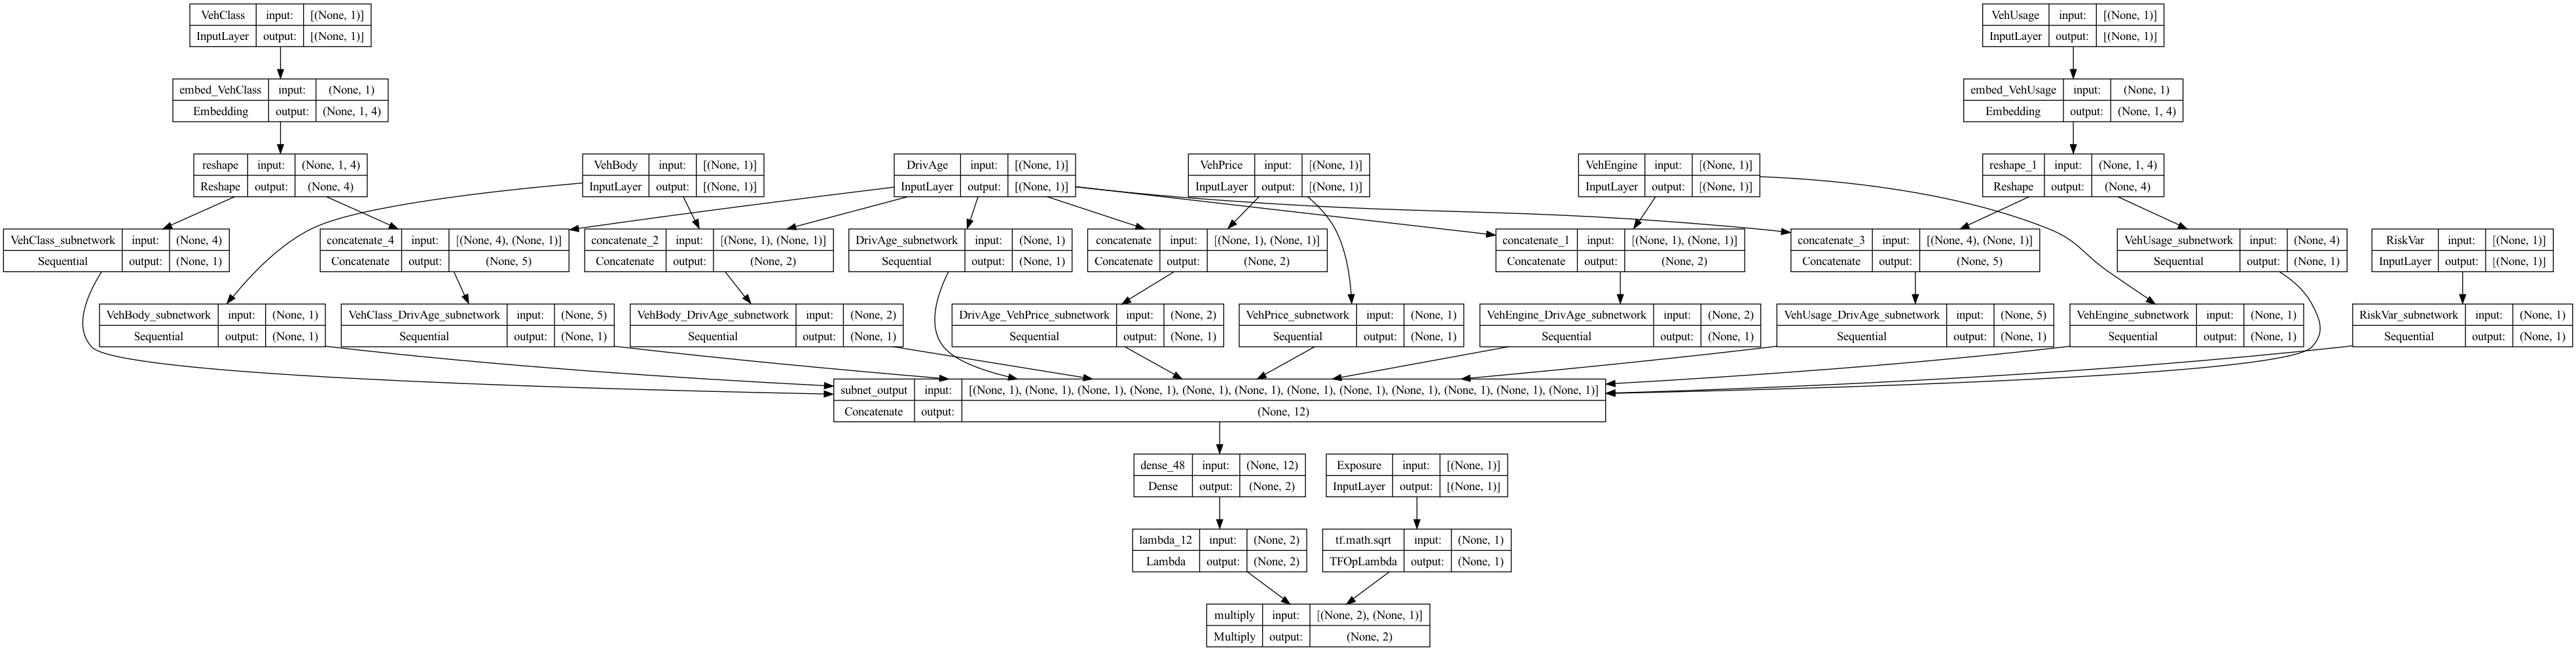

In [190]:
#-------------------------- plot model --------------------------
plot_model(model_NAM_gamma, show_layer_names = True, show_shapes = True)

In [191]:
#-------------------------- evaluate on testing data --------------------------
_, nam_gamma_rmse, nam_gamma_mae = model_NAM_gamma.evaluate(X_test_NAM_split, y_test)

21/21 [==============================] - 0s 1ms/step - loss: -2173.9109 - root_mean_squared_error: 5313.3765 - mean_absolute_error: 2648.8499


In [192]:
############################ 6. NAM WITH LOG-NORMAL DISTRIBUTION ############################

# Custom loss function for Log-Normal distribution likelihood
class LogNormalLikelihoodLoss(Loss):
    def call(self, y_true, y_pred):
        mu = y_pred[:, 0]
        sigma = y_pred[:, 1]
        epsilon = 1e-8

        # Ensure sigma is positive
        sigma = tf.math.maximum(sigma, epsilon)

        log_prob = -tf.math.log(y_true + epsilon) - tf.math.log(sigma) - 0.5 * ((tf.math.log(y_true + epsilon) - mu) / sigma) ** 2
        return -tf.reduce_mean(log_prob)


# -------------------------- define NAM with Gamma loss --------------------------
def build_NAM_lnormal(hp):

    global monotonicity
    # list of layers
    inputs = []  # Store input layers
    sub_outputs = []  # Outputs from each subnet
    interactions_input = {} # used to store layers as input for pairwise interaction effect subnet

    # hyperparameters
    num_layers_main = hp.Int('num_layers', 2, 4) # number of hidden layers for main effects' subnets
    num_layers_interaction = hp.Int('num_layers', 2, 8, step = 2) # number of hidden layers for interaction effects' subnets
    units_main = hp.Int('units_main', 5, 15, step = 2) # number of units per layer for main effect
    units_interaction = hp.Int('units_interaction', 15, 30, step = 5) # number of units per layer for interaction effect
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'swish', 'gelu'])
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step = 0.1)
    embedding_dim = hp.Int("embedding_dimension", 2, 4) # embedding dimension for categorical variables
    MINMAX_groups_main = hp.Int('num_layers', 3, 8) # number of groups of MINMAX network for main effect
    MINMAX_groups_interaction = hp.Int('num_layers', 5, 10) # number of groups of MINMAX network for interaction effect
    MINMAX_neurons_main = hp.Int('num_layers', 3, 8) # number of neurons per group of MINMAX network for main effect
    MINMAX_neurons_interaction = hp.Int('num_layers', 5, 10) # number of neurons per group of MINMAX network for interaction effect
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate for optimizer

    # main effect
    for name in feature_names_filtered:
        
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)
        interactions_input[name] = input_layer
        
        # subnetwork
        if name == "Exposure":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in embedding_vars_filtered:
            # categorical variables will pass through an embedding layer
            embed_layer = Embedding(input_dim = claim[name].nunique(), 
                        output_dim = embedding_dim,
                        name = f"embed_{name}")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (embedding_dim,))(embed_layer)
            interactions_input[name] = embed_layer_reshape # used for pairwise interaction effect
            subnet = create_subnet(num_layers_main, units_main, activation, f"{name}_subnetwork", dropout_rate)
            sub_output = subnet(embed_layer_reshape)
            sub_outputs.append(sub_output)
        else:
            if name in monotonicity:
                subnet = create_MINMAX(input_layer, num_groups = MINMAX_groups_main, 
                                    neurons_per_group = MINMAX_neurons_main, activation = activation, 
                                    monotonicity_list = [monotonicity[name]],
                                    model_name = f"{name}_subnetwork")
            else:
                subnet = create_subnet(num_layers_main, units_main, activation, f"{name}_subnetwork", dropout_rate)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)

    
    # pairwise interactions
    for (var1, var2) in pairwise_interactions:

        # get the relevant input layers
        input_layer1 = interactions_input[var1]
        input_layer2 = interactions_input[var2]

        # concatenate
        pairwise_input = Concatenate()([input_layer1, input_layer2])
        
        # create the monotonicity list
        monotonicity_list = []
        if var1 in monotonicity:
            monotonicity_list.append(monotonicity[var1])
        else:
            for _ in range(input_layer1.shape[1]):
                monotonicity_list.append("none")
        if var2 in monotonicity:
            monotonicity_list.append(monotonicity[var2])
        else:
            for _ in range(input_layer2.shape[1]):
                monotonicity_list.append("none")
                
        # subnetworks
        if var1 in monotonicity or var2 in monotonicity:
            pairwise_subnet = create_MINMAX(pairwise_input, num_groups = MINMAX_groups_interaction, 
                                            neurons_per_group = MINMAX_neurons_interaction, 
                                            activation = activation, 
                                            monotonicity_list = monotonicity_list,
                                            model_name = f"{var1}_{var2}_subnetwork")
        else:
            pairwise_subnet = create_subnet(num_layers_interaction, units_interaction, activation, 
                                            f"{var1}_{var2}_subnetwork", dropout_rate)
        pairwise_output = pairwise_subnet(pairwise_input)
        sub_outputs.append(pairwise_output)

    # combine subnets' outputs
    subnets = Concatenate(name = f"subnet_output")(sub_outputs)

    # Transform outputs for Log-Normal distribution
    mu = Dense(1, activation = "softplus")(subnets)
    sigma = Dense(1, activation = "softplus")(subnets)

    # Multiply each neuron by the square root of the exposure input
    final_mu = Multiply()([mu, exposure_input])
    final_output = Concatenate()([final_mu, sigma])
    model = Model(inputs = inputs, outputs = final_output)

    #compile and return model
    model.compile(optimizer = Adam(learning_rate = lr), loss = LogNormalLikelihoodLoss(), 
                  metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    return model


In [193]:
# -------------------------- compile and fit the model --------------------------

# hyperparameter tuning
tuner_NAM_lnormal = kt.RandomSearch(
    build_NAM_lnormal,
    objective = 'val_loss',
    max_trials = 10,
    directory = "hyperparameter_tuning_NAM_lnormal_freMPL1",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True)

# search for the best model
tuner_NAM_lnormal.search(X_train_NAM_split, y_train,
            epochs = 500,
            validation_split = 0.25,
            callbacks = [es])

# get the best model
model_NAM_lnormal = tuner_NAM_lnormal.get_best_models()[0]
tuner_NAM_lnormal.results_summary(1)

Trial 10 Complete [00h 01m 47s]
val_loss: 8.61395263671875

Best val_loss So Far: 8.311115264892578
Total elapsed time: 00h 17m 25s
Results summary
Results in hyperparameter_tuning_NAM_lnormal_freMPL1/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
num_layers: 3
units_main: 11
units_interaction: 20
activation: gelu
dropout_rate: 0.4
embedding_dimension: 4
learning_rate: 0.001787365734000676
Score: 8.311115264892578


In [194]:
#-------------------------- evaluate on testing data --------------------------
_, nam_lnormal_rmse, nam_lnormal_mae = model_NAM_lnormal.evaluate(X_test_NAM_split, y_test)

21/21 [==============================] - 0s 1ms/step - loss: 8.4049 - root_mean_squared_error: 5391.1616 - mean_absolute_error: 2381.3984


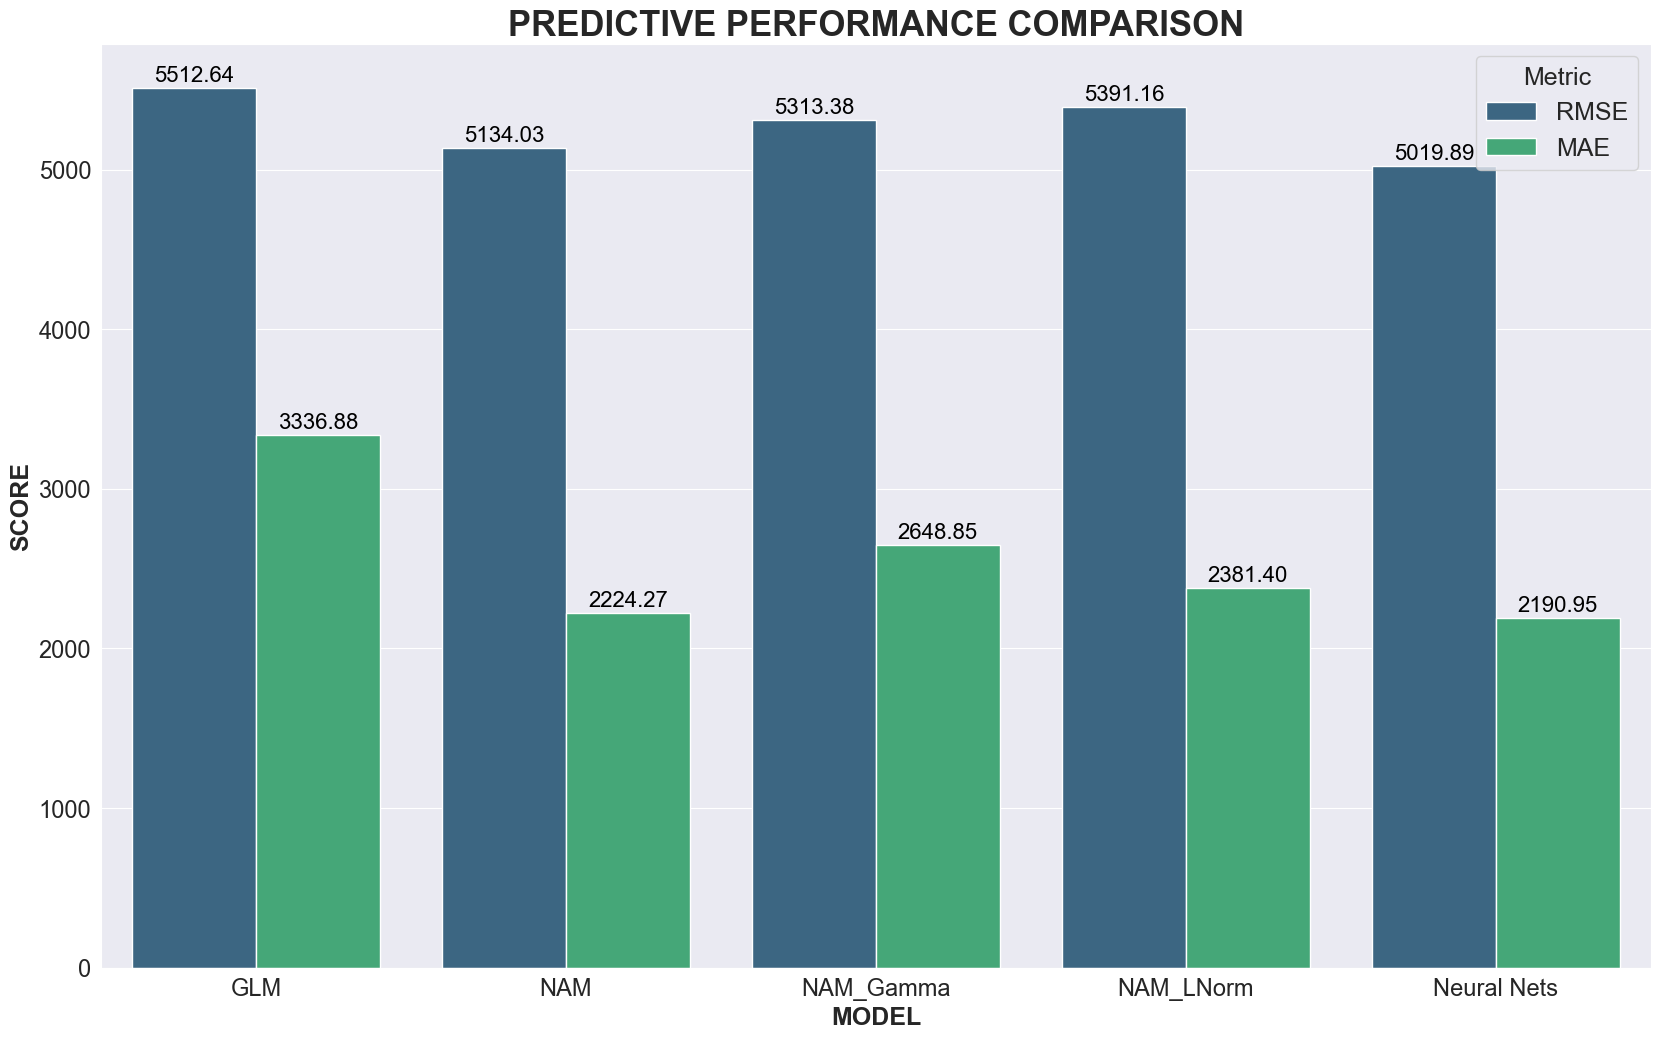

In [195]:
############################ 8. COMPARISON ############################

# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM', 'GLM', 'NAM', 'NAM', 'NAM_Gamma', 'NAM_Gamma', 
              'NAM_LNorm', 'NAM_LNorm', 'Neural Nets', 'Neural Nets'],
    'Metric': ['RMSE', 'MAE', 'RMSE', 'MAE', 'RMSE', 'MAE', 
               'RMSE', 'MAE', 'RMSE', 'MAE'],
    'Value': [GLM_rmse, GLM_mae, nam_rmse, nam_mae,
              nam_gamma_rmse, nam_gamma_mae, 
              nam_lnormal_rmse, nam_lnormal_mae,
              nn_rmse, nn_mae]
}
df_performance = pd.DataFrame(df_performance)

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (20, 12))
barplot = sns.barplot(x = 'Model', y = 'Value', hue = 'Metric', data = df_performance, palette = 'viridis')


'''AI: the code below is adapted from an answer given by ChatGPT. This is declared in the AI Appendix'''
# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.2f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 16, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON', fontsize = 25, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 18, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 18, fontweight = 'bold')
barplot.legend(title = 'Metric', fontsize = 18, title_fontsize = 18)

# size of x-label
barplot.tick_params(labelsize = 17)

# Show the plot
plt.show()

In [196]:
############################ 9. SNAM ############################
def build_SNAM(hp):

    # list of layers
    inputs = []  # Store input layers
    sub_outputs = []  # Outputs from each subnet

    # model hyperparameters
    num_neurons = 10
    num_layers = 1
    activation = 'leaky_relu'
    embedding_dim = 3

    # hyperparameters
    lambda_val = hp.Float('lambda', min_value=1e2, max_value=1e4, sampling='log')

    # main effect
    for name in feature_names:
        
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)
        
        # subnetwork
        if name == "Exposure":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in embedding_vars:
            # categorical variables will pass through an embedding layer
            embed_layer = Embedding(input_dim = claim[name].nunique(), 
                        output_dim = embedding_dim,
                        name = f"embed_{name}")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (embedding_dim,))(embed_layer)
            subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork", trainable = False)
            sub_output = subnet(embed_layer_reshape)
            sub_outputs.append(sub_output)
        else:
            subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork", trainable = False)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)

    # combine subnets' outputs
    subnets = Concatenate(name = f"subnet_output")(sub_outputs)
    output_layer = Dense(1, activation = "exponential", name = "output_layer")(subnets)

    # multiply output with exposure
    final_output = Multiply()([exposure_input, output_layer + 1e-4])
    model = Model(inputs = inputs, outputs = final_output)

    # Custom loss function
    class LassoRMSE(tf.keras.losses.Loss):
        def __init__(self, lambda_val):
            super().__init__()
            self.lambda_val = lambda_val

        def call(self, y_true, y_pred):
            mse = tf.reduce_mean(tf.square(y_true - y_pred))
            rmse = tf.sqrt(mse)
            lasso = self.lambda_val * tf.reduce_sum(tf.abs(model.get_layer("output_layer").kernel))
            return rmse + lasso

    #compile and return model
    model.compile(optimizer = "adam", loss = LassoRMSE(lambda_val = lambda_val), 
                  metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    return model

In [203]:
# -------------------------- compile and fit the model --------------------------

# hyperparameter tuning
tuner_SNAM = kt.RandomSearch(
    build_SNAM,
    objective = 'val_loss',
    max_trials = 10,
    directory = "hyperparameter_tuning_SNAM_freMPL1",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True)

# search for the best model
tuner_SNAM.search(X_train_split, y_train,
            epochs = 500,
            validation_split = 0.25,
            callbacks = [es])

# get the best model
model_SNAM= tuner_SNAM.get_best_models()[0]
tuner_SNAM.results_summary(1)

Trial 10 Complete [00h 00m 11s]
val_loss: 3602.5244140625

Best val_loss So Far: 3601.628662109375
Total elapsed time: 00h 01m 55s
Results summary
Results in hyperparameter_tuning_SNAM_freMPL1/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
lambda: 164.68966822474474
Score: 3601.628662109375


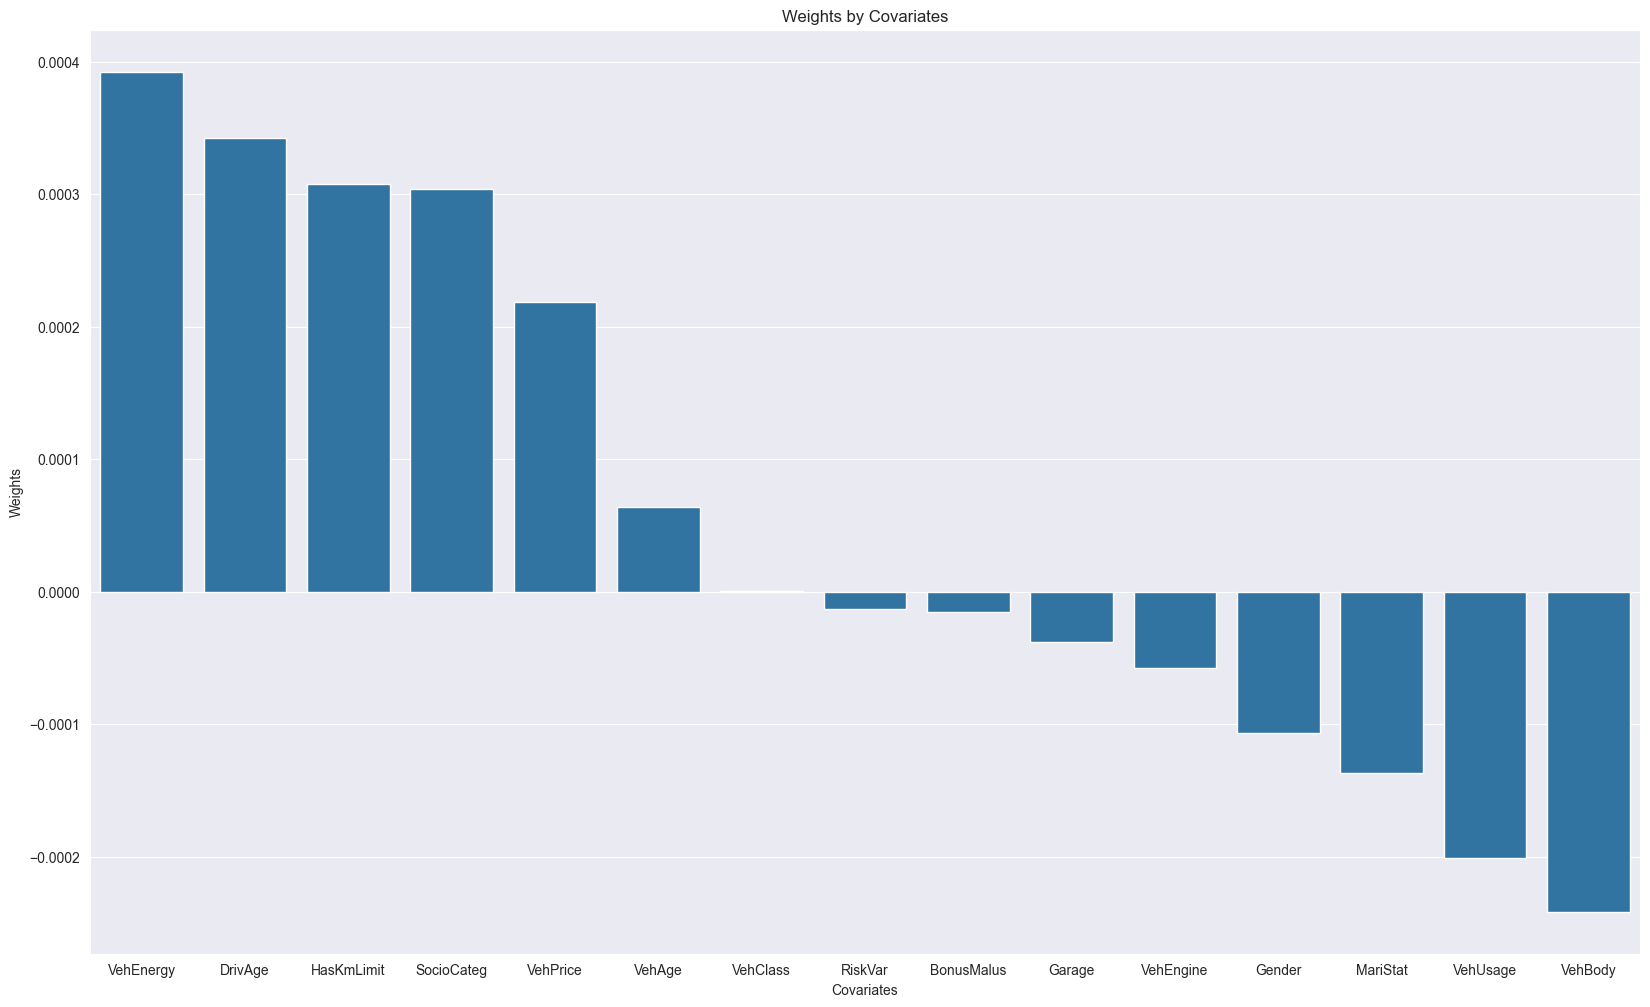

In [204]:
# -------------------------- quantify variable importance --------------------------
output_weight = model_SNAM.get_layer("output_layer").kernel.numpy()  # Get the weights of the last layer
output_weight = output_weight.flatten()

# -------------------------- plot the variable importance --------------------------
weights = pd.DataFrame({"Covariates": covariates, "Weights": output_weight})

# Sort the DataFrame by subnet variance in decreasing order
weights_sorted = weights.sort_values(by = "Weights", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 12))
sns.barplot(x = "Covariates", y = "Weights", data = weights_sorted)
plt.title("Weights by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Weights")
plt.show()